# TP2 - Julien Vanbelle

## Imports

In [36]:
##imports
import os
import yake
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image
from collections import defaultdict
import sys
import spacy
from spacy.lang.fr.examples import sentences
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from tabulate import tabulate
## variables
year = 1890
data_path = "/Users/julienvanbelle/Documents/GitHub/tac/data/txt" ## /!\ à changer 
temp_path = '/Users/julienvanbelle/Documents/GitHub/tac/data'     ## /!\ à changer
all_path = "/Users/julienvanbelle/Documents/GitHub/tac/data/all.txt" ## /!\ à changer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extraction des mots clés

In [19]:
# Stopwords
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville","conseil communal", "conseil général", "conseil d'administration","conseil supérieur","conseil provincial","conseil"]
sw = set(sw)

In [20]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [21]:
# Lister les Fichiers
files = os.listdir(data_path)

In [22]:
# Imprimer le nombre de fichiers identifiés
len(files)

2829

In [23]:
# Enlever les fichiers qui ne commencent pas par Bxl_
date_files = [f for f in files if f.startswith('Bxl_1890')]
len(date_files)

22

Fonction d'extraction des mots clés

In [24]:
for f in sorted(date_files):
    text = open(os.path.join(data_path, f), 'r').read()
    keywords = kw_extractor.extract_keywords(text.lower())
    kept = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2 and kw.lower() not in sw:
            kept.append(kw)
    print(f"{f} mentions these keywords: {', '.join(kept)}...")

Bxl_1890_Tome_I1_Part_1.txt mentions these keywords: l'administration communale...
Bxl_1890_Tome_I1_Part_2.txt mentions these keywords: travaux manuels, droits acquis, qu'il serait, nouvelle caisse, l'echevin andré...
Bxl_1890_Tome_I1_Part_3.txt mentions these keywords: dépenses ordinaires, tramways bruxellois, conseil académique, arts décoratifs, dépenses extraordinaires...
Bxl_1890_Tome_I1_Part_4.txt mentions these keywords: voie publique, tramways bruxellois...
Bxl_1890_Tome_I1_Part_5.txt mentions these keywords: mètres cubes, mètre cube, d'un terrain, rue nouvelle, mètre carré...
Bxl_1890_Tome_I1_Part_6.txt mentions these keywords: élèves internes, rue neuve, service médical, l'honorable bourgmestre, rue nouvelle...
Bxl_1890_Tome_I1_Part_7.txt mentions these keywords: place rouppe, grande distinction, l'echevin janssen...
Bxl_1890_Tome_I1_Part_8.txt mentions these keywords: élèves internes, service médical, service. art, élèves externes, nommé membre...
Bxl_1890_Tome_I2_Part_1.txt 

In [25]:
# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in date_files:
    with open(os.path.join(data_path, txt), 'r') as f:
        content_list.append(f.read())

len(content_list)

22

In [26]:
# Ecrire tout le contenu dans un fichier temporaire
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'{year}.txt'), 'w') as f:
    f.write(' '.join(content_list))

In [27]:
# Imprimer le contenu du fichier et constater les "déchets"
with open(os.path.join(temp_path, f'{year}.txt'), 'r') as f:
    before = f.read()

before[:500]

"—\n\n307 —\n\nD. — Canal de Bruxelles au Rupel.\n\nRelevé des diverses recettes effectuées pendant les années 1 8 8 0\nà 1889 et les six premiers mois de l'armée 1890.\n\nPRODUIT\n\nDROIT\n\nA DU CCS.\n\nTOTAL GENERAL.\n\ndes\nDE\n\nNAVIGATION.\n\nd r o i t s de q n i l t a B c e .\n\n1880\n\n535,968\n\n65\n\n1,765\n\n60\n\n357,754\n\n25\n\n1881\n\n3 1 8 , 9 8 8 47\n\n2,080\n\n»\n\n321,068\n\n47\n\n1882\n\n5 1 1 , 7 4 9 34\n\n2,065\n\n10\n\n315,814\n\n44\n\n1883\n\n279,778\n\n03\n\n1,863\n\n60\n\n281,645\n\n65\n\n1884\n\n281,616\n\n46\n\n1,882\n\n80\n\n285,499\n\n26\n\n1885\n\n277,147\n"

Fonction de nettoyage

In [28]:
def clean_text(year, folder=None):
    if folder is None:
        input_path = f"{year}.txt"
        output_path = f"{year}_clean.txt"
    else:
        input_path = f"{folder}/{year}.txt"
        output_path = f"{folder}/{year}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [29]:
clean_text(year, folder=temp_path)

'Output has been written in /Users/julienvanbelle/Documents/GitHub/tac/data/1890_clean.txt!'

In [30]:
# Vérifier le résultat
with open(os.path.join(temp_path, f'{year}_clean.txt'), 'r') as f:
    after = f.read()

after[:500]

'canal bruxelles rupel relevé diverses recettes effectuées années six premiers mois armée produit droit ccs total general navigation six premiers mois entrepôt public ëfal indiquant vins boissons distillées eau vie emmagasinées public douanes années six premiers mois année quantité quantité entrée janvier entrepôt janvier espèce liquide total décembre exercice quantité quantité sortie restant janvier décembre décembre convertis total dernières colonnes hect eau vie étrang indigène hect vinaigre e'

In [31]:
frequencies = Counter(after.split())
print(frequencies.most_common(10))

[('francs', 2746), ('rue', 1665), ('art', 1612), ('collège', 1431), ('service', 1113), ('bruxelles', 1036), ('gaz', 1022), ('echevin', 1021), ('frais', 823), ('honorable', 823)]


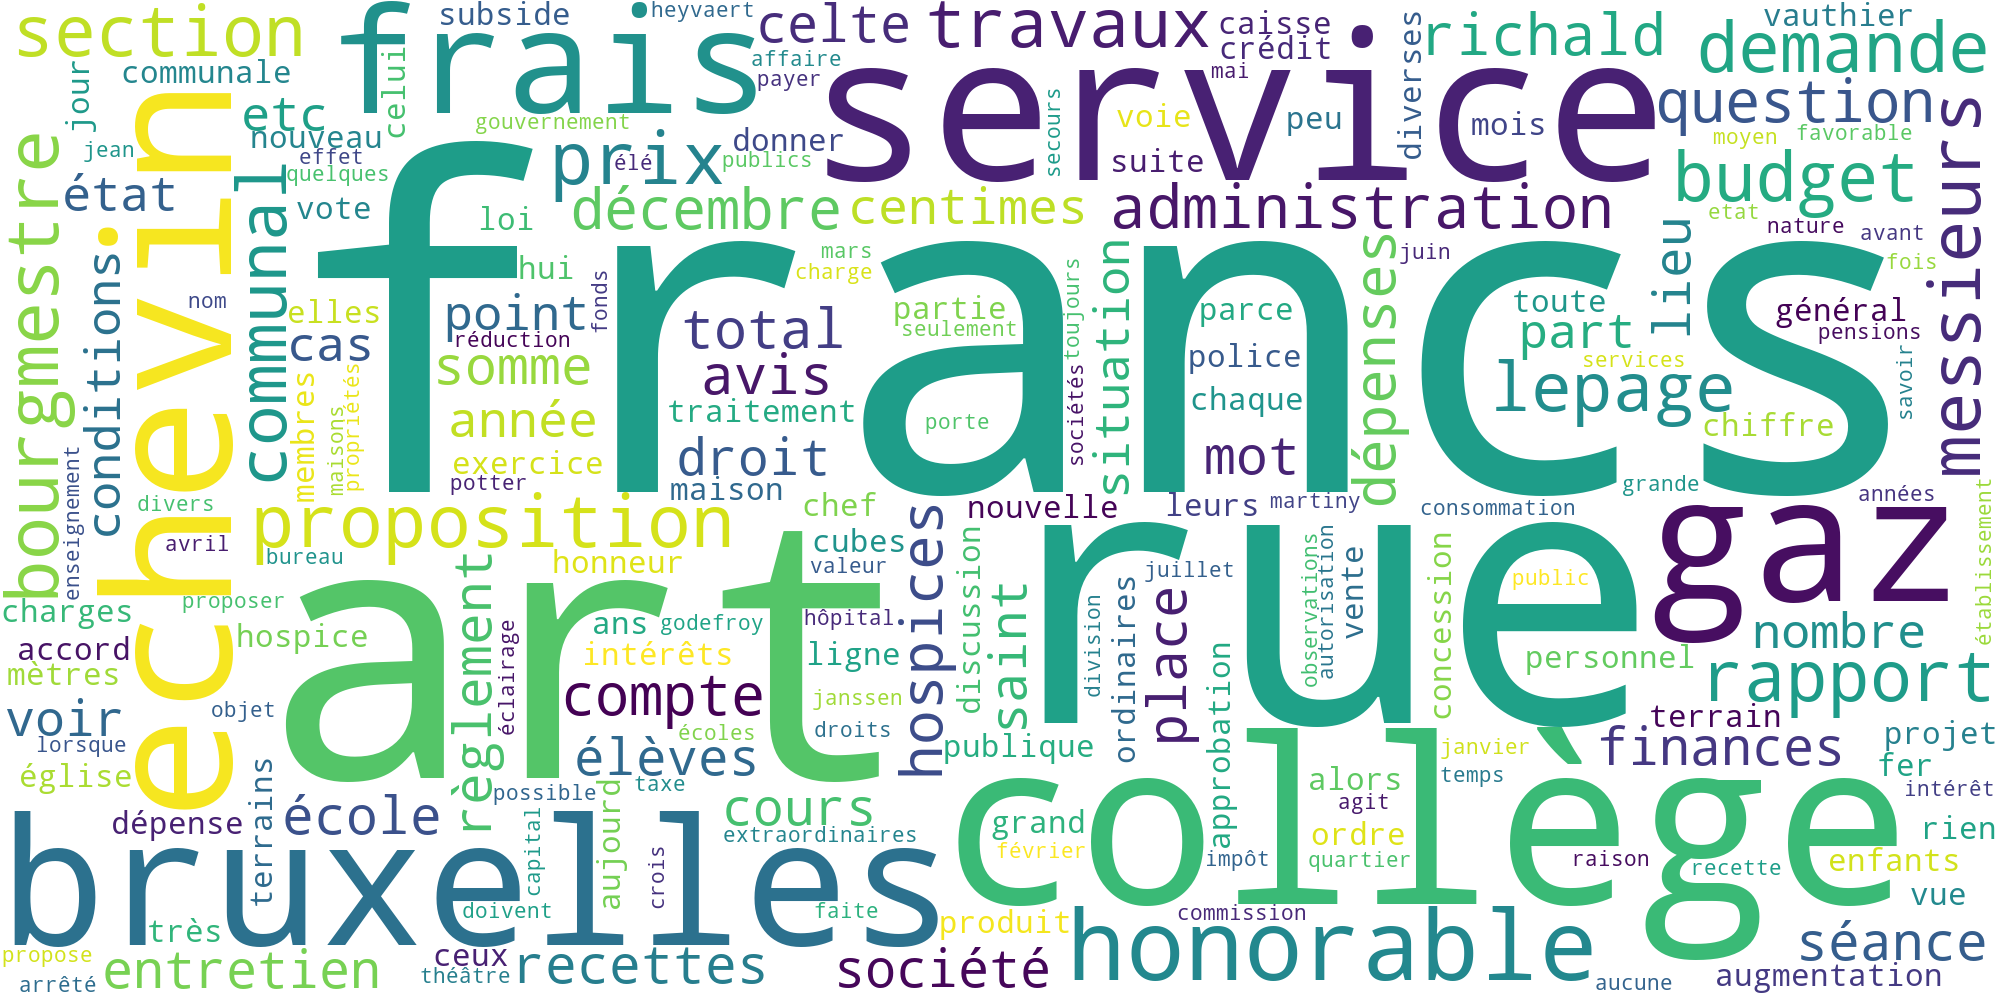

In [32]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"{year}.png"))
Image(filename=os.path.join(temp_path, f"{year}.png"))

## Recherche des entités nommées principales

In [33]:
nlp = spacy.load('fr_core_news_md')

In [37]:
# Charger le texte
n=900000
text = open(all_path, encoding='utf-8').read()[:n]

In [38]:
%%time
# Traiter le texte

doc = nlp(text)

CPU times: user 2min 3s, sys: 9.35 s, total: 2min 12s
Wall time: 2min 26s


In [39]:
# Compter les entités
people = defaultdict(int)
organisation = defaultdict(int)
places = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
    if ent.label_ == "ORG" and len(ent.text) > 3:
        organisation[ent.text] += 1
    if ent.label_ == "LOC" and len(ent.text) > 3:
        places[ent.text] += 1
      
    
      

In [40]:
# Trier et imprimer

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_organisation = sorted(organisation.items(), key=lambda kv: kv[1], reverse=True)
sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)


for person, freq in sorted_people:
    print(f"{person} (PER)apparait {freq} fois dans le corpus")

for organisation, freq in sorted_organisation:
    print(f"{organisation} (ORG)apparait {freq} fois dans le corpus")

for places, freq in sorted_places:
    print(f"{places} (LOC)apparait {freq} fois dans le corpus")

Gendebien (PER)apparait 118 fois dans le corpus
q u i (PER)apparait 101 fois dans le corpus
Bortier (PER)apparait 75 fois dans le corpus
Bourgmestre (PER)apparait 56 fois dans le corpus
Doucet (PER)apparait 44 fois dans le corpus
Messieurs (PER)apparait 34 fois dans le corpus
Vanderlinden (PER)apparait 31 fois dans le corpus
Anspach (PER)apparait 30 fois dans le corpus
Doncker (PER)apparait 29 fois dans le corpus
M. Bortier (PER)apparait 25 fois dans le corpus
Page (PER)apparait 25 fois dans le corpus
Cans (PER)apparait 24 fois dans le corpus
Fontainas (PER)apparait 23 fois dans le corpus
q u ' i (PER)apparait 18 fois dans le corpus
échevin Orts (PER)apparait 17 fois dans le corpus
j o u r (PER)apparait 15 fois dans le corpus
Cluysenaar (PER)apparait 15 fois dans le corpus
Schumacher (PER)apparait 15 fois dans le corpus
é t a i (PER)apparait 10 fois dans le corpus
M. Gendebien (PER)apparait 10 fois dans le corpus
M. Cluysenaar (PER)apparait 10 fois dans le corpus
M. Blaes (PER)apparait

In [41]:
phrase_list = []

phrase1 = "C'est dire que vous avez des facultés et des aptitudes spéciales pour l'art auquel vous avez consacré votre vie."
phrase2 = "Les artistes musiciens et choristes du théâtre de l'Alhambra sollicitent un subside à l'effet de pouvoir organiser des concerts classiques et hebdomadaires."
phrase3 = "M. Yseux. J'ai posé la question de savoir si le fait est vrai ou faux."
phrase4 = "Dans ces conditions, nous espérons que la Députation permanente refusera de mandater d'office une dépense qui légalement nenous incombe pas. Au besoin, la justice sera appelée à statuer."
phrase5 = "Le directeur fait, à la fin de chaque mois, le dépouillement des certificats délivrés par les chefs de service aux internes et aux externes et le transmet au Secrétariat général."
phrase6 = "Il prépare les médicaments nécessaires et surveille l'administration de ceux-ci ; il ne peut modifier en rien les traitements indiqués par le médecin directeur, ni en instituer aucun autre, lorsque celui-ci est à l'hospice."
phrase7 = "Dans la dernière séance, nous avons voté poulies fêtes un crédit supplémentaire de 53,000 francs."
phrase8 = "Il était néanmoins difficile de la combler parce que, d'une part, les crédits votés par le Conseil communal devaient subvenir à de multiples emplois, et que, d'autre part, le crédit voté par les Chambres était des plus réduits."
phrase9 = "Nous ne pouvons mieux faire c o n n a î t r e la situation p r o s p è r e de l'Académie qu'en mentionnant le nombre d'élèves q u i ont é t é inscrits pour les cours d u soir, soit 7 5 9 , ce q u i , avec les 259 jeunes gens inscrits pour les cours du j o u r , forme un total de 1,018 élèves ; beaucoup d'entre eux se sont fait inscrire à la fois pour les cours du jour et du soir."
phrase10 = "Grâce à la généreuse intervention du fonds Bischoffsheim, l'ouverture de l'école a eu lieu le 9 septembre 1889."
phrase_list.append(phrase1)
phrase_list.append(phrase2)
phrase_list.append(phrase3)
phrase_list.append(phrase4)
phrase_list.append(phrase5)
phrase_list.append(phrase6)
phrase_list.append(phrase7)
phrase_list.append(phrase8)
phrase_list.append(phrase9)
phrase_list.append(phrase10)

##print(phrase_list[:10])
print("nb d'éléments dans la liste =",len(phrase_list))

nb d'éléments dans la liste = 10


Fonction d'analyse de sentiment

In [49]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
score_list = [['Phrase','Polarity', 'Subjectivity']]
def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")
    score_list.append([y+1,polarity_str,subjectivity_str])


Analyse des phrases 

In [50]:


for y in range(0,len(phrase_list)):
 print("Phrase", y+1, "==" ,phrase_list[y])
 get_sentiment(phrase_list[y])
 print()
 print(score_list[y+1])
 print()


 

Phrase 1 == C'est dire que vous avez des facultés et des aptitudes spéciales pour l'art auquel vous avez consacré votre vie.
This text is 50% positive and 0.5% subjective.

[1, '50% positive', '0.5% subjective']

Phrase 2 == Les artistes musiciens et choristes du théâtre de l'Alhambra sollicitent un subside à l'effet de pouvoir organiser des concerts classiques et hebdomadaires.
This text is 70% positive and 0.2% subjective.

[2, '70% positive', '0.2% subjective']

Phrase 3 == M. Yseux. J'ai posé la question de savoir si le fait est vrai ou faux.
This text is 6% negative and 0.4% subjective.

[3, '6% negative', '0.4% subjective']

Phrase 4 == Dans ces conditions, nous espérons que la Députation permanente refusera de mandater d'office une dépense qui légalement nenous incombe pas. Au besoin, la justice sera appelée à statuer.
This text is neutral and 0.1% subjective.

[4, 'neutral', '0.1% subjective']

Phrase 5 == Le directeur fait, à la fin de chaque mois, le dépouillement des certifi

Création d'un tableau récapitulatif de la polarité et de la subjectivité de chaque phrase

In [51]:
print(tabulate(score_list,headers='firstrow',tablefmt='fancy_grid'))

╒══════════╤══════════════╤══════════════════════════════════╕
│   Phrase │ Polarity     │ Subjectivity                     │
╞══════════╪══════════════╪══════════════════════════════════╡
│        1 │ 50% positive │ 0.5% subjective                  │
├──────────┼──────────────┼──────────────────────────────────┤
│        2 │ 70% positive │ 0.2% subjective                  │
├──────────┼──────────────┼──────────────────────────────────┤
│        3 │ 6% negative  │ 0.4% subjective                  │
├──────────┼──────────────┼──────────────────────────────────┤
│        4 │ neutral      │ 0.1% subjective                  │
├──────────┼──────────────┼──────────────────────────────────┤
│        5 │ 3% negative  │ 0.019999999999999997% subjective │
├──────────┼──────────────┼──────────────────────────────────┤
│        6 │ 16% positive │ 0.1% subjective                  │
├──────────┼──────────────┼──────────────────────────────────┤
│        7 │ 0% positive  │ 0.16666666666666666% subjec